# Dataset and Split

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

data = load_iris()

X,Y = data.data, data.target

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,stratify=Y ,random_state=42)

df_train = pd.concat([pd.DataFrame(x_train, columns=data.feature_names),pd.DataFrame(y_train, columns=['class'])],axis=1)
df_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,4.4,2.9,1.4,0.2,0
1,4.9,2.5,4.5,1.7,2
2,6.8,2.8,4.8,1.4,1
3,4.9,3.1,1.5,0.1,0
4,5.5,2.5,4.0,1.3,1
...,...,...,...,...,...
115,4.9,3.6,1.4,0.1,0
116,4.7,3.2,1.3,0.2,0
117,5.5,4.2,1.4,0.2,0
118,6.9,3.1,4.9,1.5,1


# Data vizualization

## Scatter Matrix

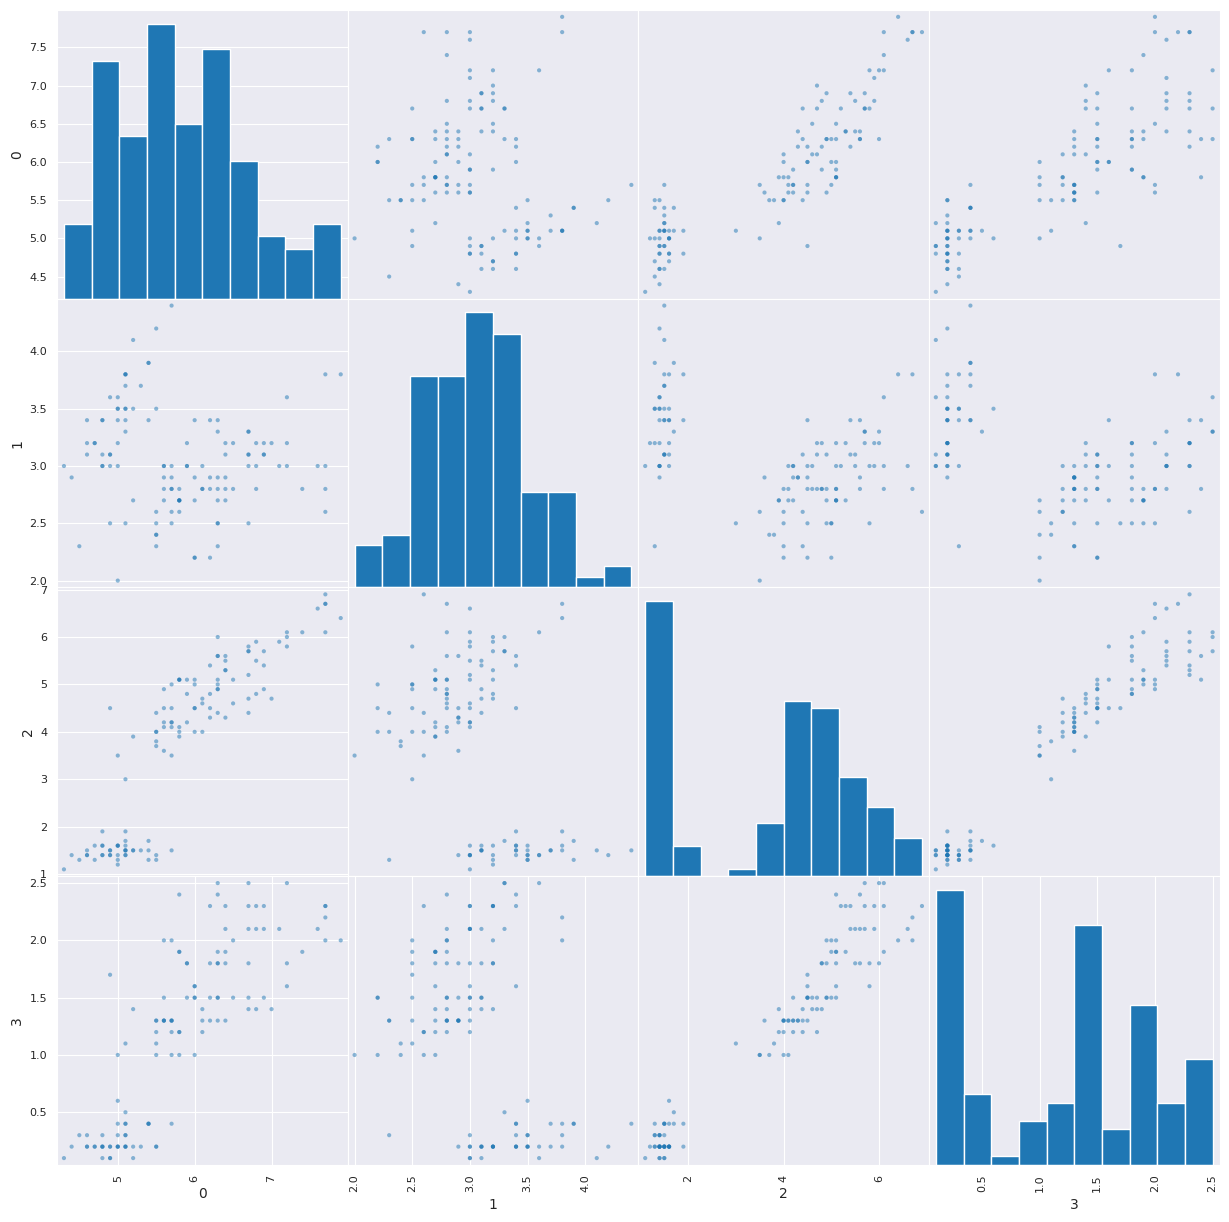

In [2]:
from pandas.plotting import scatter_matrix

df_x_train = pd.DataFrame(x_train)
scatter_matrix(df_x_train, figsize=(15,15))

plt.show()

## Correlation Matrix

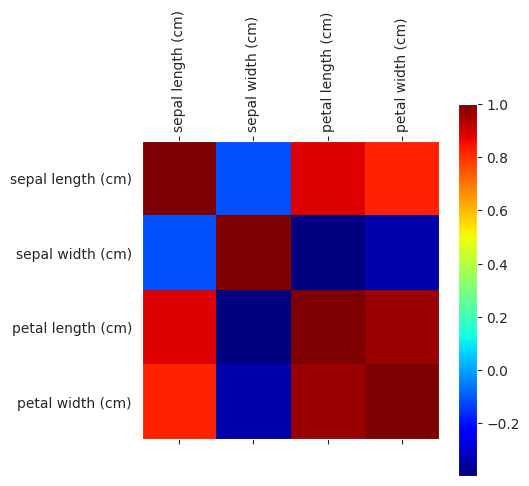

,0,1,2,3
0,1.000000,-0.112327,0.880401,0.820297
1,-0.112327,1.000000,-0.398502,-0.338741
2,0.880401,-0.398502,1.000000,0.963693
3,0.820297,-0.338741,0.963693,1.000000


In [3]:
names = data.feature_names
corr_mtx = (df_x_train).corr(method='pearson')
plt.matshow(corr_mtx, cmap="jet")
plt.colorbar()

plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.grid(False)
plt.show()

corr_mtx

# Metric function

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

roc_area_macro=1.0


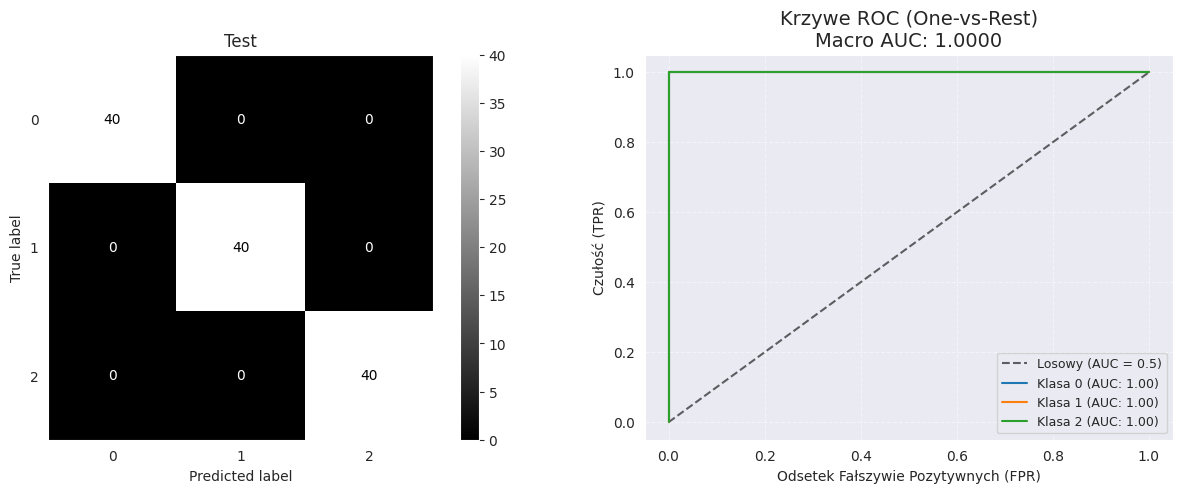

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

def metric(preds, probs, true_labels, title):

    classes = np.unique(true_labels)
    true_labels_bin = label_binarize(true_labels, classes=classes)

    #Metrics
    cr = classification_report(true_labels, preds)
    cf_mtx = confusion_matrix(true_labels, preds)


    auc_scores = []
    for c in classes:
        auc_score = roc_auc_score(true_labels_bin[:, c], probs[:, c])
        auc_scores.append(auc_score)

    roc_area_macro = np.mean(auc_scores)

    #Ploting
    fig, (ax_cfmtx, ax_roc) = plt.subplots(1,2, figsize=(15,5))


    #Roc curves
    ax_roc.set_title(f'Krzywe ROC (One-vs-Rest)\nMacro AUC: {roc_area_macro:.4f}', fontsize=14)
    ax_roc.plot([0, 1], [0, 1], 'k--', label='Losowy (AUC = 0.5)', alpha=0.6)
    for c in classes:
        fpr, tpr, _ = roc_curve(true_labels_bin[:, c], probs[:, c])
        ax_roc.plot(fpr, tpr,label=f'Klasa {classes[c]} (AUC: {auc_scores[c]:.2f})')

    ax_roc.set_xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
    ax_roc.set_ylabel('Czułość (TPR)')
    ax_roc.legend(loc="lower right", fontsize=9)
    ax_roc.grid(linestyle='--', alpha=0.5)

    #Confusion matrix
    ax_cfmtx.set_title(title)
    ax_cfmtx.grid(False)
    ax_cfmtx = ConfusionMatrixDisplay(confusion_matrix=cf_mtx).plot(ax = ax_cfmtx, cmap="grey")

    print(title)
    print(cr)
    print(f'{roc_area_macro=}')

classes = np.unique(y_train)
metric(y_train, label_binarize(y_train, classes=classes), y_train, 'Test')

# Optimize, train and judge

In [5]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import time

def selected_features(selector):
    global names

    mask = selector.get_support()
    selected_names = np.array(names)[mask]
    return list(selected_names)


def optimize_train_and_judge(title, scaler_class, model_class, objective_fn, trails=100):
    global x_train, y_train, x_test, y_test

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)
    stop = time.time()


    pipe = Pipeline([('scaler',scaler_class()),('features_selector', RFE(estimator=DecisionTreeClassifier())) ,('classifier', model_class())])
    pipe.set_params(**study.best_params)
    pipe.fit(x_train, y_train)


    ## Metrics
    preds = pipe.predict(x_test)
    probs = pipe.predict_proba(x_test)
    metric(preds, probs, y_test, title)

    selector = pipe.named_steps['features_selector']
    names_selected = selected_features(selector)
    features_shape = [x_test.shape[0], len(names_selected)]
    print(f"Selected features: {names_selected}")
    print(f"Optimize time: {stop-start}")

    return pipe

# Scalers

In [6]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

class RoubustMinMaxScaler(BaseEstimator):
    def __init__(self, q_r:tuple[int] = (25, 75)):
        self.q_r = q_r

    def fit(self, X, Y=None):

        [qa, qb] = np.quantile(X, q=self.q_r, axis=0)
        self.qa = qa
        self.qb = qb

        return self

    def transform(self, X):
        x_std = (X - self.qa) / (self.qb - self.qa)
        return x_std

## Standard Scaler and Logistic regression

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from typing import Literal


def ulitmate_objective_generator(scaler_name:Literal['standard', 'minmax', 'robust', 'robustMinMax'], model_name:Literal['Logistic', 'KNN']):

    scaler_class = None
    model_class = None

    if scaler_name == 'standard':
        scaler_class = StandardScaler

    elif scaler_name == 'minmax':
        scaler_class = MinMaxScaler

    elif scaler_name == 'robust':
        scaler_class = RobustScaler

    elif scaler_name == 'robustMinMax':
        scaler_class = RoubustMinMaxScaler

    if model_name == 'Logistic':
        model_class = LogisticRegression
    elif model_name == 'KNN':
        model_class = KNeighborsClassifier



    def objective(trial):
        #Scalers
        nonlocal scaler_class, model_class
        model_params = {}
        scaler_params = {}

        if scaler_class is StandardScaler:

            scaler_params = {}

        if scaler_class is MinMaxScaler:
            clip = trial.suggest_categorical('scaler__clip', [True, False])

            scaler_params = {'clip': clip}

        if scaler_class is RobustScaler:
            with_centering=trial.suggest_categorical('scaler__with_centering', [True, False])
            quantile_range = trial.suggest_categorical('scaler__quantile_range', [(0.1, 0.9), (0.25, 0.75), (0.3, 0.7), (0.4, 0.6)])

            scaler_params = {'with_scaling': True, 'with_centering': with_centering, 'quantile_range': quantile_range}

        if scaler_class is RoubustMinMaxScaler:
            q_r = trial.suggest_categorical('scaler__q_r', [(0.1, 0.9), (0.25, 0.75), (0.3, 0.7), (0.4, 0.6)])


            scaler_params = {'q_r': q_r}

        # Feature Selection
        n_features_to_select = trial.suggest_int('features_selector__n_features_to_select', 1, 4)


        # Models
        if model_class is LogisticRegression:
            C = trial.suggest_float('classifier__C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('classifier__solver', ['lbfgs', 'liblinear', 'saga'])
            max_iter = trial.suggest_int('classifier__max_iter', 100, 200)

            model_params = {'C': C, 'solver': solver, 'max_iter': max_iter}

        if model_class is KNeighborsClassifier:
            n_neighbors = trial.suggest_int("classifier__n_neighbors", 1, 80)
            weights = trial.suggest_categorical('classifier__weights', ['uniform', 'distance'])
            metric  = trial.suggest_categorical('classifier__metric', ['manhattan', 'euclidean','minkowski'])

            model_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

        pipe = Pipeline([('scaler', scaler_class(**scaler_params)),('features_selector', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features_to_select)) ,
                     ('classifier', model_class(**model_params))])

        pipe.fit(x_train, y_train)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(pipe, x_train, y_train, cv=cv, scoring= 'roc_auc_ovr').mean()

        return score

    return [scaler_class, model_class, objective]

# Different Trials

In [14]:
import optuna
import warnings
warnings.filterwarnings("ignore")
optuna.logging.disable_default_handler()


scalers = ['standard', 'minmax', 'robust', 'robustMinMax']
models = ['Logistic', 'KNN']

objectives = {}

for s in scalers:
    for m in models:
        objectives[f'{m} with {s} scaler'] = ulitmate_objective_generator(s, m)


objectives

{'Logistic with standard scaler': [sklearn.preprocessing._data.StandardScaler,
  sklearn.linear_model._logistic.LogisticRegression,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'KNN with standard scaler': [sklearn.preprocessing._data.StandardScaler,
  sklearn.neighbors._classification.KNeighborsClassifier,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'Logistic with minmax scaler': [sklearn.preprocessing._data.MinMaxScaler,
  sklearn.linear_model._logistic.LogisticRegression,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'KNN with minmax scaler': [sklearn.preprocessing._data.MinMaxScaler,
  sklearn.neighbors._classification.KNeighborsClassifier,
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'Logistic with robust scaler': [sklearn.preprocessing._data.RobustScaler,
  sklearn.linear_model._logistic.LogisticRegression,
  <function __main__.ulitmate_object

# Train&Judge

  0%|          | 0/50 [00:00<?, ?it/s]

Logistic with standard scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

roc_area_macro=0.9966666666666667
Selected features: ['petal length (cm)', 'petal width (cm)']
Optimize time: 2.263812780380249


  0%|          | 0/50 [00:00<?, ?it/s]

KNN with standard scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

roc_area_macro=0.9966666666666667
Selected features: ['petal length (cm)', 'petal width (cm)']
Optimize time: 2.169231414794922


  0%|          | 0/50 [00:00<?, ?it/s]

Logistic with minmax scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

roc_area_macro=1.0
Selected features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Optimize time: 2.445131301879883


  0%|          | 0/50 [00:00<?, ?it/s]

KNN with minmax scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

roc_area_macro=0.9966666666666667
Selected features: ['petal length (cm)', 'petal width (cm)']
Optimize time: 2.1269381046295166


  0%|          | 0/50 [00:00<?, ?it/s]

Logistic with robust scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

roc_area_macro=1.0
Selected features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Optimize time: 4.728857755661011


  0%|          | 0/50 [00:00<?, ?it/s]

KNN with robust scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

roc_area_macro=0.9933333333333333
Selected features: ['petal length (cm)', 'petal width (cm)']
Optimize time: 2.3521440029144287


  0%|          | 0/50 [00:00<?, ?it/s]

Logistic with robustMinMax scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

roc_area_macro=1.0
Selected features: ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Optimize time: 2.458644151687622


  0%|          | 0/50 [00:00<?, ?it/s]

KNN with robustMinMax scaler
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

roc_area_macro=0.9966666666666667
Selected features: ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Optimize time: 2.253593921661377


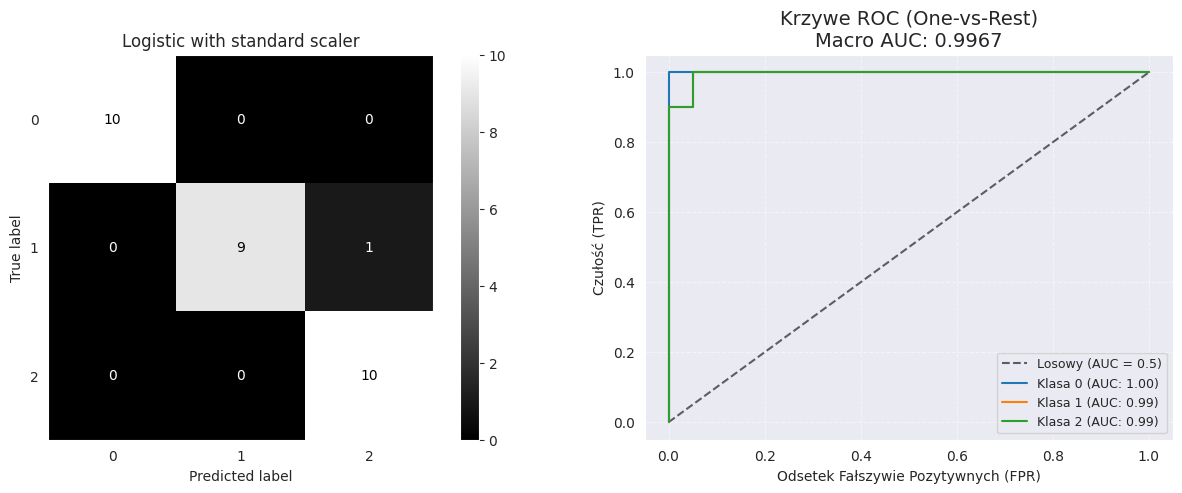

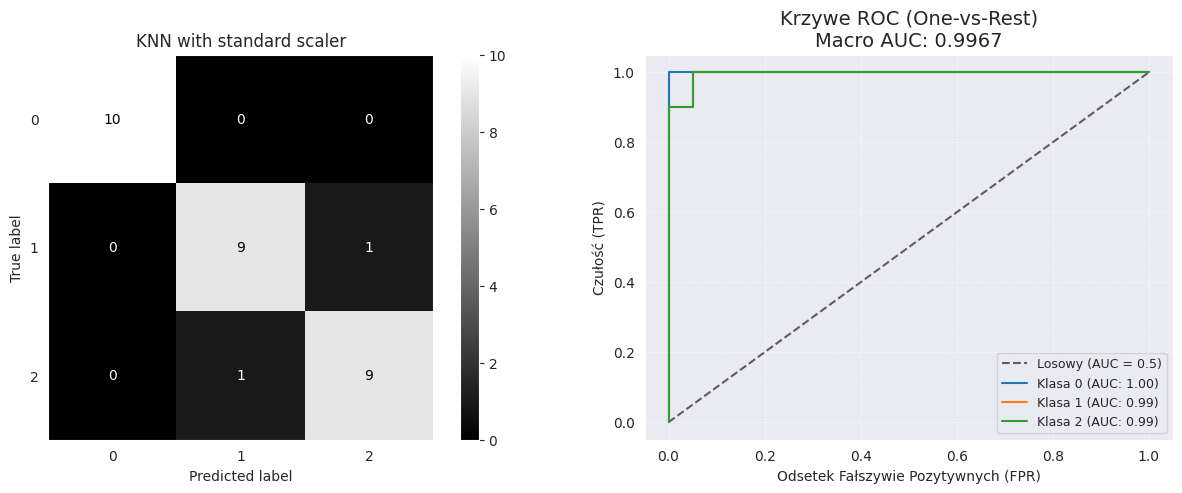

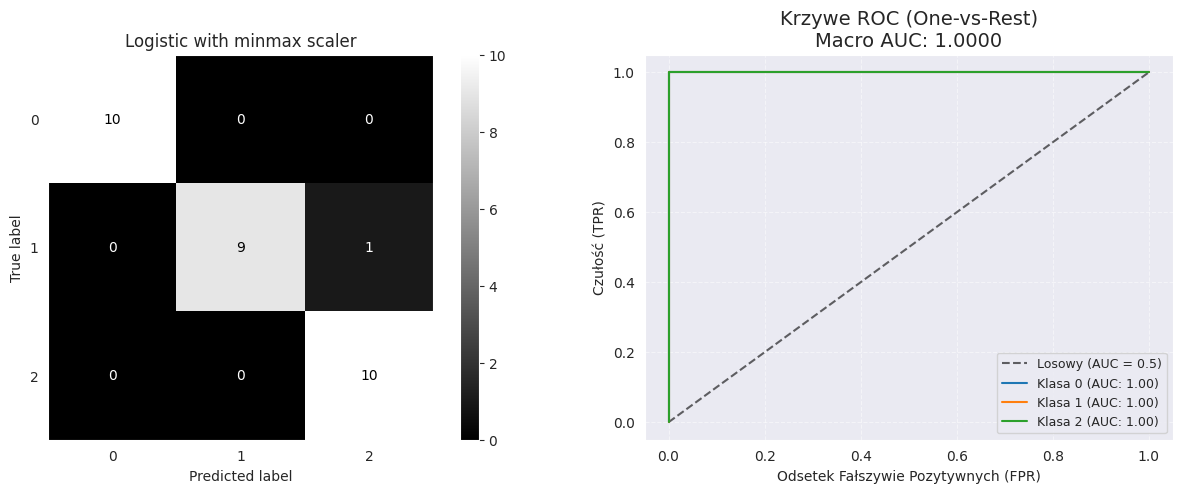

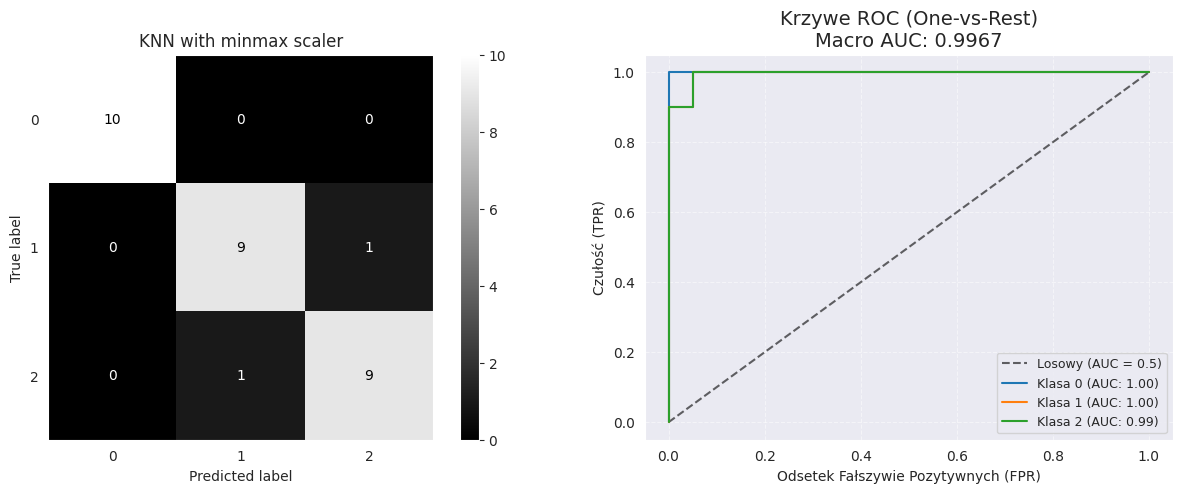

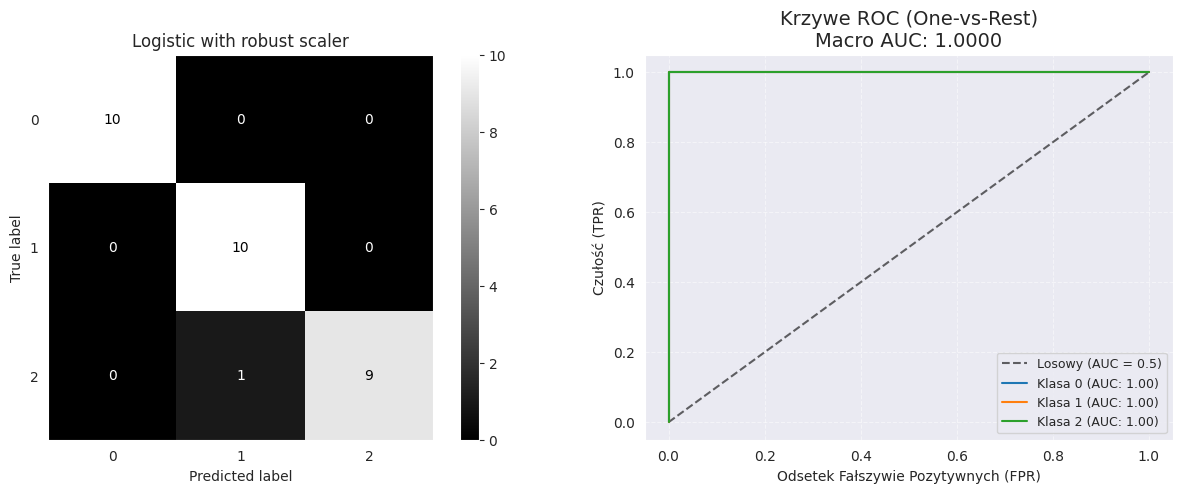

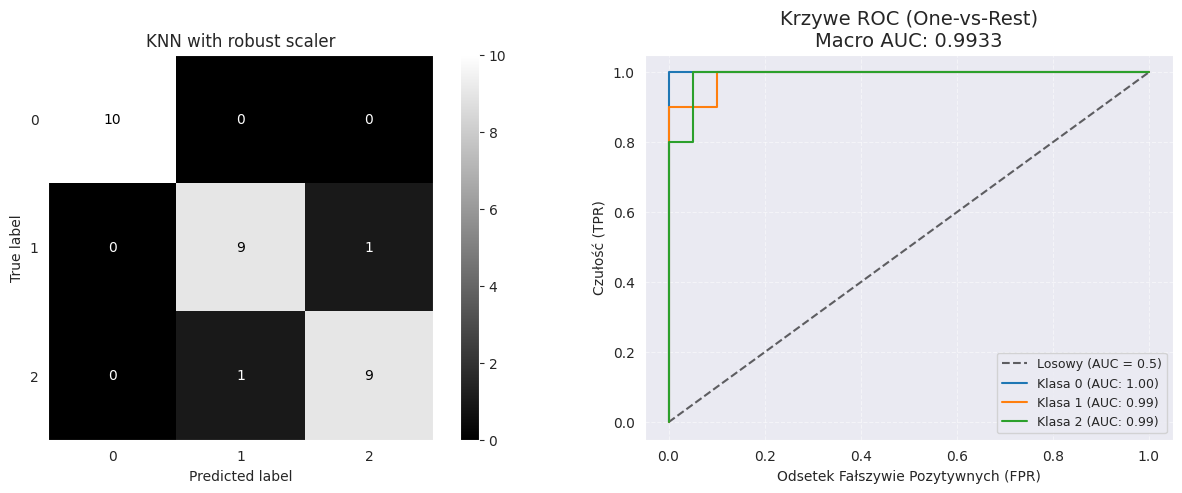

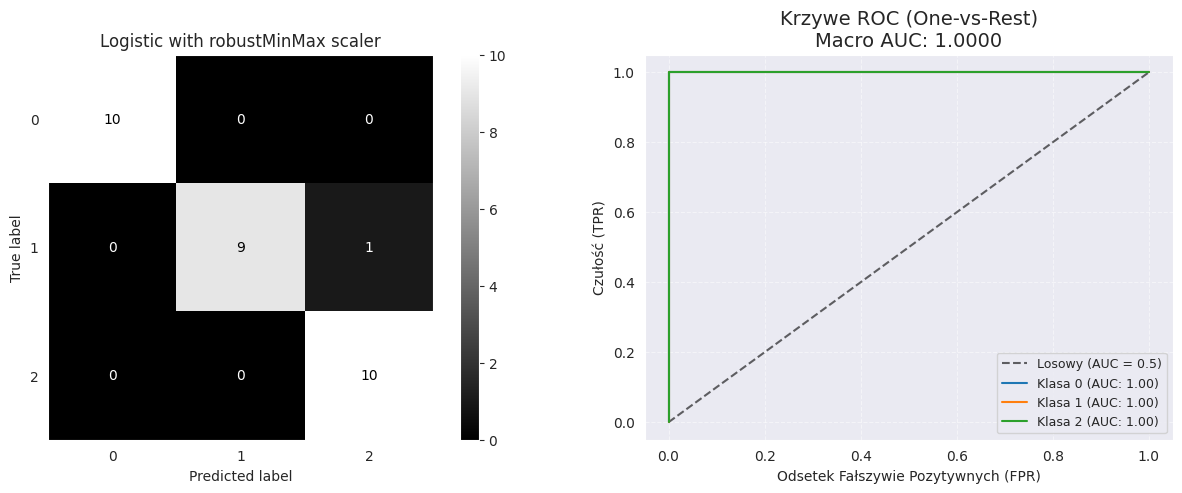

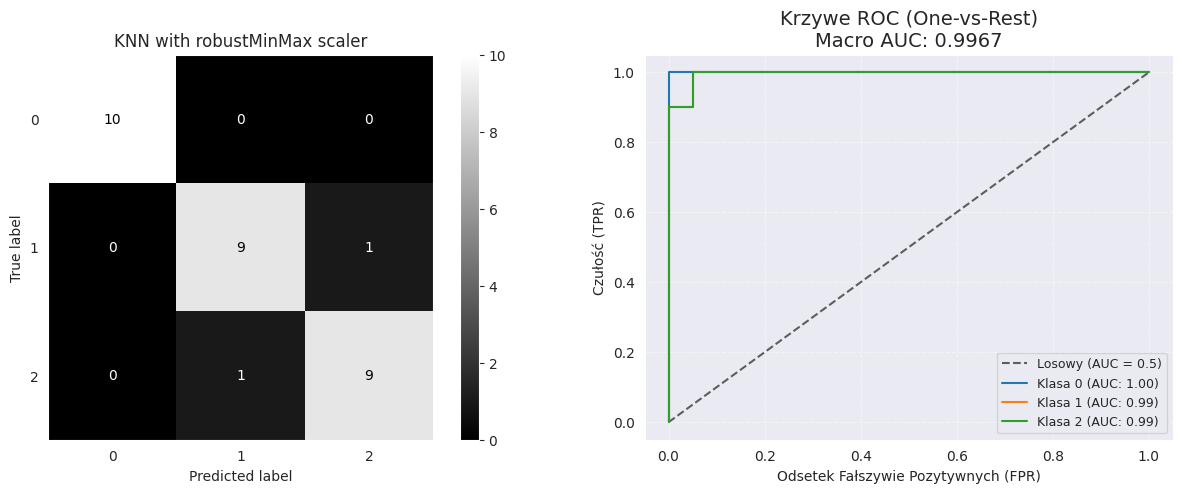

In [15]:

import logging

pipes = {}
optuna.logging.set_verbosity(logging.WARNING)
for name in objectives.keys():
    pipes[name] = optimize_train_and_judge(title=name, scaler_class=objectives[name][0], model_class=objectives[name][1], objective_fn=objectives[name][2], trails=50)



# Pipes

In [10]:
pipes

{'Logistic with standard scaler': Pipeline(steps=[('scaler', StandardScaler()),
                 ('features_selector',
                  RFE(estimator=DecisionTreeClassifier(),
                      n_features_to_select=4)),
                 ('classifier',
                  LogisticRegression(C=19.71353010817949, max_iter=184,
                                     solver='saga'))]),
 'KNN with standard scaler': Pipeline(steps=[('scaler', StandardScaler()),
                 ('features_selector',
                  RFE(estimator=DecisionTreeClassifier(),
                      n_features_to_select=3)),
                 ('classifier',
                  KNeighborsClassifier(n_neighbors=32, weights='distance'))]),
 'Logistic with minmax scaler': Pipeline(steps=[('scaler', MinMaxScaler(clip=True)),
                 ('features_selector',
                  RFE(estimator=DecisionTreeClassifier(),
                      n_features_to_select=1)),
                 ('classifier',
                  Logi